In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation as cv
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import r2_score

In [29]:
rec_df = pd.read_csv('rec-with-percentage-no-dup.csv')
rec_df = rec_df.sample(frac=1).reset_index(drop=True)
train_data, test_data = cv.train_test_split(rec_df, test_size=0.20)

In [30]:
from sklearn import cross_validation as cv
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt

n_users = rec_df.user_id.unique().shape[0]
n_items = rec_df.reading_id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of readings = ' + str(n_items))

Number of users = 239 | Number of readings = 7


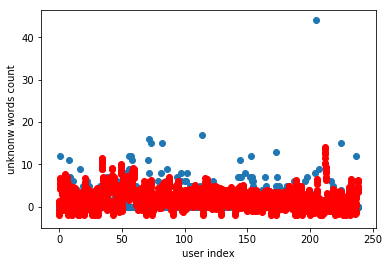

User-based CF RMSE: 3.2805187310600274
Item-based CF RMSE: 3.155562260394428
Percent Correct User-based: 0.5642558278541542
Percent Correct Item-based: 0.4674237895995218
coefficient of determination User-based: -1.38764736472
coefficient of determination Item-based: -1.20921838473
Full User-based CF RMSE Avg: 3.2805187310600274
Full Item-based CF RMSE Avg: 3.155562260394428
User-based CF Correct Percent Avg: 0.5642558278541542
Item-based CF Correct Percent Avg: 0.4674237895995218
User-based coefficient of determination Avg: -1.38764736472
Item-based coefficient of determination Avg: -1.20921838473


In [31]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

def rmseWithoutZeors(prediction, ground_truth):
    prediction = prediction[np.where(ground_truth >= 0)].flatten()
    ground_truth = ground_truth[np.where(ground_truth >= 0)].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

def rmse(prediction, ground_truth):
    prediction = prediction.flatten()
    ground_truth = ground_truth.flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

def coefficient_of_determination(prediction, ground_truth):
    prediction = prediction.flatten()
    ground_truth = ground_truth.flatten()
    return r2_score(ground_truth, prediction)

def percentCorrect(prediction, ground_truth, bound):
    prediction = prediction[np.where(ground_truth >= 0)].flatten()
    ground_truth = ground_truth[np.where(ground_truth >= 0)].flatten()
    in_bound = 0
    for index, x in enumerate(prediction):
        if (x <= ground_truth[index] + bound and x >= ground_truth[index] - bound):
            in_bound = in_bound + 1
    return in_bound/len(prediction)

def normalize_ratings(ratings):
    num_movies = ratings.shape[0]
    
    ratings_mean = np.zeros(shape = (num_movies, 1))
    ratings_norm = np.zeros(shape = ratings.shape)
    
    for i in range(num_movies): 
        # Get all the indexes where there is a 1
        idx = np.where(ratings[i] >= 0)[0]
        #  Calculate mean rating of ith movie only from user's that gave a rating
        ratings_mean[i] = np.mean(ratings[i, idx])
        ratings_norm[i, idx] = ratings[i, idx] - ratings_mean[i]
    
    return ratings_norm, ratings_mean

user_prediction_rmse_sum = 0
item_prediction_rmse_sum = 0
user_percent_correct_sum = 0
item_percent_correct_sum = 0
user_coefficient_sum = 0
item_coefficient_sum = 0

training_repeat = 1
for x in range(0, training_repeat):
    full_data = np.empty((n_users, n_items))
    full_data[:] = 0
    for line in rec_df.itertuples():
        full_data[line[1]-1, line[2]-1] = line[5]
    
    train_data, test_data = cv.train_test_split(rec_df, test_size=0.20)
    
    train_data_matrix = np.empty((n_users, n_items))
    train_data_matrix[:] = 0
    for line in train_data.itertuples():
        train_data_matrix[line[1]-1, line[2]-1] = line[5]

    test_data_matrix = np.empty((n_users, n_items))
    test_data_matrix[:] = 0
    for line in test_data.itertuples():
        test_data_matrix[line[1]-1, line[2]-1] = line[5]
        
    user_ratings, user_ratings_mean = normalize_ratings(train_data_matrix)
    item_ratings, item_ratings_mean = normalize_ratings(train_data_matrix.T)
    
    
    user_similarity = pairwise_distances(user_ratings, metric='cosine')
    item_similarity = pairwise_distances(item_ratings.T, metric='cosine')

    user_prediction = predict(user_ratings, user_similarity, type='user')
    item_prediction = predict(item_ratings, item_similarity, type='item')
    
    user_prediction = user_prediction + user_ratings_mean
    item_prediction = item_prediction + item_ratings_mean
    
    truth = []
    user_prediction_arr = []
    for (x,y), value in np.ndenumerate(test_data_matrix):
        if (value != -1):
            truth.append([x, y, value])
            user_prediction_arr.append([x, y, user_prediction[x][y]])
    # draw graph
    truth_df = pd.DataFrame(truth)
    user_prediction_arr_df = pd.DataFrame(user_prediction_arr)
    plt.scatter(truth_df.iloc[:,0], truth_df.iloc[:,2])
    plt.scatter(user_prediction_arr_df.iloc[:,0], user_prediction_arr_df.iloc[:,2], c='red')
    plt.xlabel('user index')
    plt.ylabel('unknonw words count')
    plt.show()
    
    # evaluation of prediction
    user_prediction_rmse = rmse(user_prediction, test_data_matrix)
    user_prediction_rmse_sum = user_prediction_rmse_sum + user_prediction_rmse
    item_prediction_rmse = rmse(item_prediction.T, test_data_matrix)
    item_prediction_rmse_sum = item_prediction_rmse_sum + item_prediction_rmse
    print('User-based CF RMSE: ' + str(user_prediction_rmse))
    print('Item-based CF RMSE: ' + str(item_prediction_rmse))
    
    user_percent_correct = percentCorrect(user_prediction, test_data_matrix, 2)
    user_percent_correct_sum = user_percent_correct_sum + user_percent_correct
    item_percent_correct = percentCorrect(item_prediction.T, test_data_matrix, 2)
    item_percent_correct_sum = item_percent_correct_sum + item_percent_correct
    print('Percent Correct User-based: ' + str(user_percent_correct))
    print('Percent Correct Item-based: ' + str(item_percent_correct))
    
    user_coefficient = coefficient_of_determination(user_prediction, test_data_matrix)
    user_coefficient_sum = user_coefficient_sum + user_coefficient
    item_coefficient = coefficient_of_determination(item_prediction.T, test_data_matrix)
    item_coefficient_sum = item_coefficient_sum + item_coefficient
    print('coefficient of determination User-based: ' + str(user_coefficient))
    print('coefficient of determination Item-based: ' + str(item_coefficient))
    
print('Full User-based CF RMSE Avg: ' + str(user_prediction_rmse_sum/training_repeat))
print('Full Item-based CF RMSE Avg: ' + str(item_prediction_rmse_sum/training_repeat))
print('User-based CF Correct Percent Avg: ' + str(user_percent_correct_sum/training_repeat))
print('Item-based CF Correct Percent Avg: ' + str(item_percent_correct_sum/training_repeat))
print('User-based coefficient of determination Avg: ' + str(user_coefficient_sum/training_repeat))
print('Item-based coefficient of determination Avg: ' + str(item_coefficient_sum/training_repeat))
